In [18]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# 데이터 경로 후보
train_candidates = [
    Path("../data/29757_train_merged.csv"),
    Path("../data/1000_train_merged.csv"),
    Path("../data/10000_train_merged.csv"),
]
test_candidates = [
    Path("../data/29757_test_merged.csv"),
    Path("../data/1000_test_merged.csv"),
    Path("../data/10000_test_merged.csv"),
]


def resolve_path(candidates: list[Path]) -> Path:
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"No dataset found in: {candidates}")


train_path = resolve_path(train_candidates)
test_path = resolve_path(test_candidates)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_col = "died_in_icu"
possible_group_cols = ["patientunitstayid", "patient_id"]
possible_time_cols = ["observationoffset"]

group_col = next((c for c in possible_group_cols if c in train_df.columns), None)
time_col = next((c for c in possible_time_cols if c in train_df.columns), None)

if group_col is None or time_col is None:
    raise ValueError("patient id or time column not found")

# base feature: 숫자형 + 타깃/ID만 제외 (time_col은 포함)
numeric_cols = train_df.select_dtypes(include=["number"]).columns

exclude = {
    target_col,          # died_in_icu
    "patient_id",
    "patientunitstayid",
}  # time_col(observationoffset)은 제외하지 않음

base_cols = [c for c in numeric_cols if c not in exclude]




def add_missing_and_time_features(df: pd.DataFrame, base_cols: list[str]) -> pd.DataFrame:
    df = df.sort_values([group_col, time_col]).copy()

    for col in base_cols:
        miss = df[col].isna().astype(int)
        last_time = df[time_col].where(df[col].notna()).groupby(df[group_col]).ffill()
        tsince = df[time_col] - last_time
        tsince = tsince.fillna(df[time_col])  # 첫 측정 전 구간은 입실 후 경과시간으로 대체

        df[f"{col}_miss"] = miss
        df[f"{col}_tsince"] = tsince

    return df


def impute_base(df: pd.DataFrame, base_cols: list[str], medians: pd.Series) -> pd.DataFrame:
    df = df.sort_values([group_col, time_col]).copy()
    df[base_cols] = df.groupby(group_col, sort=False)[base_cols].ffill()
    df[base_cols] = df[base_cols].fillna(medians)
    return df

# 결측치 처리(훈련 기준 중앙값)
train_medians = train_df[base_cols].median()

train_proc = add_missing_and_time_features(train_df, base_cols)
test_proc = add_missing_and_time_features(test_df, base_cols)

train_proc = impute_base(train_proc, base_cols, train_medians)
test_proc = impute_base(test_proc, base_cols, train_medians)

feature_cols = (
    base_cols
    + [f"{c}_miss" for c in base_cols]
    + [f"{c}_tsince" for c in base_cols]
)
# stayid별 최대 10개 샘플로 축소 + 92:8 클래스 비율 맞추기 (train만)
def sample_k_per_stay(df, group_col, time_col, k=10, random_state=42):
    df = df.sort_values([group_col, time_col]).copy()

    def pick_rows(g):
        n = len(g)
        if n <= k:
            return g
        # 균등 간격으로 k개 선택
        idx = np.linspace(0, n - 1, k, dtype=int)
        return g.iloc[idx]

    return df.groupby(group_col, group_keys=False).apply(pick_rows)


def balance_ratio(df, target_col="died_in_icu", ratio_pos=0.08, random_state=42):
    # ratio_pos = 사망 비율 (0.08)
    pos = df[df[target_col] == 1]
    neg = df[df[target_col] == 0]

    # pos가 적으면 neg를 줄여서 맞춤
    desired_neg = int(len(pos) * (1 - ratio_pos) / ratio_pos)

    if desired_neg >= len(neg):
        # neg가 부족하면 pos를 줄여서 맞춤
        desired_pos = int(len(neg) * ratio_pos / (1 - ratio_pos))
        pos = pos.sample(n=desired_pos, random_state=random_state)
    else:
        neg = neg.sample(n=desired_neg, random_state=random_state)

    out = pd.concat([pos, neg]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return out







/var/folders/6v/1_79rvdd7kn_cz07rmxph3p40000gn/T/ipykernel_93691/2837480734.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(pick_rows)


In [27]:
# 1) stayid별 최대 10개로 축소
train_proc = sample_k_per_stay(train_proc, group_col, time_col, k=10)
test_proc = sample_k_per_stay(test_proc, group_col, time_col, k=10)

# 2) 클래스 비율 92:8로 맞추기 (train만)
train_proc = balance_ratio(train_proc, target_col=target_col, ratio_pos=0.08)
test_proc = balance_ratio(test_proc, target_col=target_col, ratio_pos=0.08)
# feature/label 다시 구성
X_train = train_proc[feature_cols]
y_train = train_proc[target_col]

# test는 그대로
X_test = test_proc[feature_cols]
y_test = test_proc[target_col]

/var/folders/6v/1_79rvdd7kn_cz07rmxph3p40000gn/T/ipykernel_93691/2837480734.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(pick_rows)
/var/folders/6v/1_79rvdd7kn_cz07rmxph3p40000gn/T/ipykernel_93691/2837480734.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(pick_rows)


[np.int64(19006), np.int64(4753)] [np.int64(218569), np.int64(54659)]
8.0
92.0


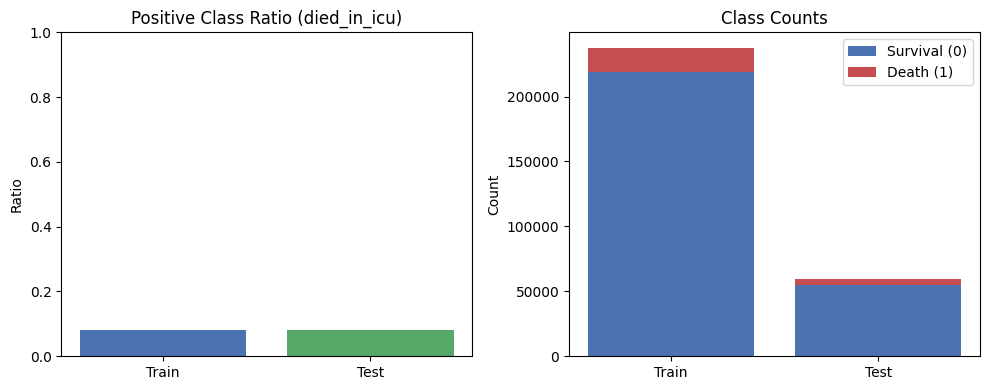

In [28]:
import matplotlib.pyplot as plt

def plot_class_ratio(train_df, test_df, target_col="died_in_icu"):
    sets = ["Train", "Test"]
    dfs = [train_df, test_df]

    ratios = [df[target_col].mean() for df in dfs]
    counts_pos = [df[target_col].sum() for df in dfs]
    counts_neg = [len(df) - p for df, p in zip(dfs, counts_pos)]
    print(counts_pos, counts_neg)
    print(counts_pos[0]/237575*100)
    print(counts_neg[0]/237575*100)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # 비율 막대
    axes[0].bar(sets, ratios, color=["#4C72B0", "#55A868"])
    axes[0].set_title("Positive Class Ratio (died_in_icu)")
    axes[0].set_ylabel("Ratio")
    axes[0].set_ylim(0, 1)

    # 실제 카운트 막대
    x = range(len(sets))
    axes[1].bar(x, counts_neg, label="Survival (0)", color="#4C72B0")
    axes[1].bar(x, counts_pos, bottom=counts_neg, label="Death (1)", color="#C44E52")
    axes[1].set_xticks(list(x))
    axes[1].set_xticklabels(sets)
    axes[1].set_title("Class Counts")
    axes[1].set_ylabel("Count")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# 샘플링/밸런싱 이후 결과로 시각화
plot_class_ratio(train_proc, test_proc, target_col)


In [12]:
# 생존/사망별 타임스탬프(observationoffset) 기초 통계 출력
def print_time_stats_by_class(df, time_col="observationoffset", target_col="died_in_icu", name="Train"):
    stats = df.groupby(target_col)[time_col].describe()
    print(f"\n[{name}] {time_col} stats by class")
    print(stats)

print_time_stats_by_class(train_df, time_col=time_col, target_col=target_col, name="Train")
print_time_stats_by_class(test_df, time_col=time_col, target_col=target_col, name="Test")



[Train] observationoffset stats by class
                 count          mean           std  min     25%     50%  \
died_in_icu                                                               
0            4788948.0   8542.256359  11250.832043  0.0  1373.0  4057.0   
1              79620.0  10818.957448  12251.023422  0.0  2223.0  6736.0   

                  75%      max  
died_in_icu                     
0            11099.00  85728.0  
1            15111.25  84833.0  

[Test] observationoffset stats by class
                 count          mean           std  min     25%     50%  \
died_in_icu                                                               
0            1198218.0   8573.001200  11264.398461  0.0  1381.0  4099.0   
1              19755.0  10635.994634  12665.539191  0.0  1747.5  6056.0   

                 75%      max  
died_in_icu                    
0            11145.0  83796.0  
1            15337.5  80514.0  


In [17]:
8542/4868568*100


0.17545200149201984

## 데이터 누수 확인

In [25]:
from sklearn.metrics import roc_auc_score


# 단일 피처 AUC 계산(샘플링해서 빠르게)
sample_df = train_df[[target_col] + base_cols].dropna(subset=[target_col]).sample(
    min(200000, len(train_df)), random_state=42
)

aucs = []
y = sample_df[target_col].values
for c in base_cols:
    x = sample_df[c].values
    if np.nanstd(x) == 0:
        continue
    # NaN은 임시로 중앙값
    x = np.where(np.isnan(x), np.nanmedian(x), x)
    try:
        aucs.append((c, roc_auc_score(y, x)))
    except Exception:
        pass

aucs = sorted(aucs, key=lambda t: t[1], reverse=True)[:30]
print(pd.DataFrame(aucs, columns=["col","auc"]))

                  col       auc
0            feature4  0.587475
1            feature3  0.581432
2   observationoffset  0.576717
3            feature1  0.575774
4           feature12  0.523220
5           feature35  0.513896
6           feature21  0.511855
7           feature29  0.509148
8           feature31  0.506691
9           feature15  0.505019
10          feature18  0.504460
11          feature13  0.503876
12          feature22  0.503844
13          feature16  0.503323
14          feature17  0.502900
15          feature34  0.500000
16          feature30  0.499844
17          feature19  0.499732
18          feature28  0.499692
19          feature14  0.499489
20          feature24  0.498159
21          feature26  0.496455
22          feature23  0.496304
23          feature32  0.495428
24          feature33  0.494829
25          feature27  0.492369
26          feature20  0.492290
27           feature7  0.487108
28          feature25  0.487019
29          feature11  0.479178


In [26]:
train_p = set(train_df[group_col].unique())
test_p  = set(test_df[group_col].unique())
overlap = train_p & test_p
print("overlap patients:", len(overlap))

overlap patients: 0


## 모델 학습

In [29]:
models: dict[str, object] = {
    "LR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]),
    "RF": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced",
    ),
}

try:
    import xgboost as xgb
    models["XGBoost"] = xgb.XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )
except Exception:
    pass

try:
    import lightgbm as lgb
    models["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
    )
except Exception:
    pass


def aggregate_patient_scores(df: pd.DataFrame, scores: np.ndarray):
    tmp = df[[group_col, target_col]].copy()
    tmp["score"] = scores
    y_patient = tmp.groupby(group_col)[target_col].max()
    s_patient = tmp.groupby(group_col)["score"].mean()
    return y_patient, s_patient


pred_scores_patient = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        raw = model.decision_function(X_test)
        scores = 1 / (1 + np.exp(-raw))

    y_patient, s_patient = aggregate_patient_scores(test_proc, scores)
    pred_scores_patient[name] = s_patient

print("models used:", list(pred_scores_patient.keys()))
print("patient-level n:", len(y_patient))


[LightGBM] [Info] Number of positive: 19006, number of negative: 218569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13584
[LightGBM] [Info] Number of data points in the train set: 237575, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080000 -> initscore=-2.442347
[LightGBM] [Info] Start training from score -2.442347
models used: ['LR', 'RF', 'XGBoost', 'LightGBM']
patient-level n: 7355


# ROC + Calibration + Decision Curve 시각화

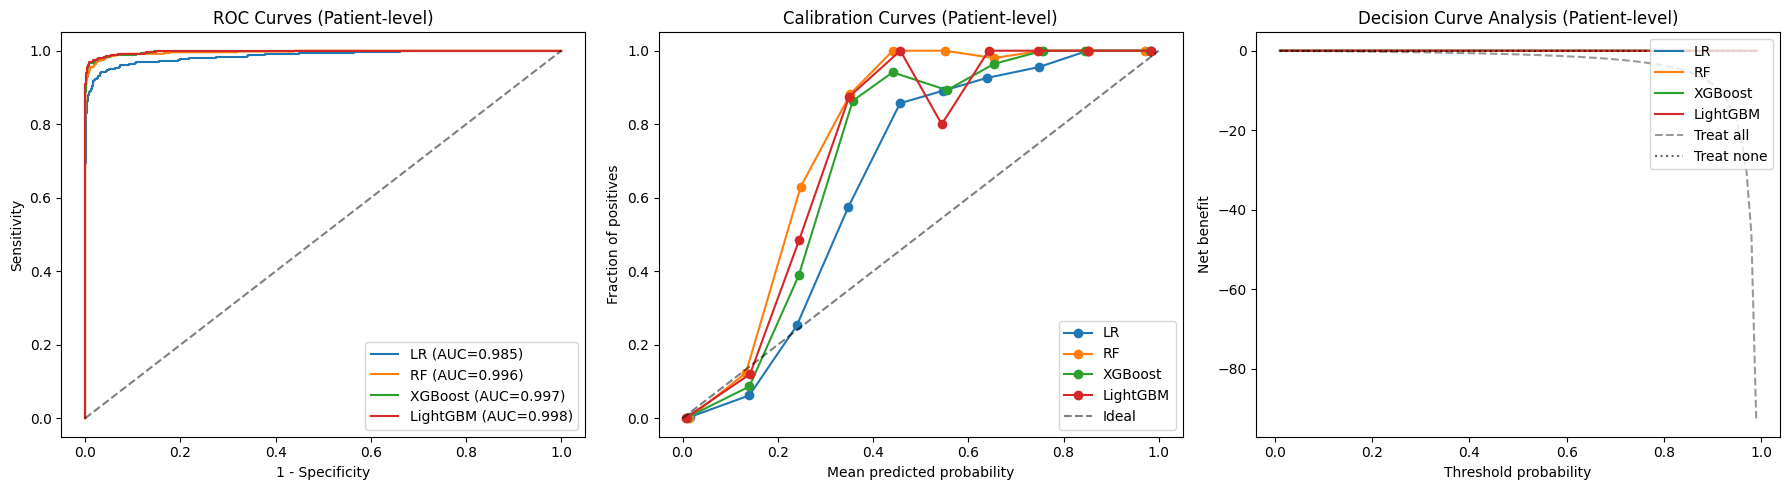

In [30]:
# 시각화만: ROC + Calibration + Decision Curve를 서브플롯(1x3)로
# 환자 단위 집계 결과 사용: y_patient, pred_scores_patient
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) ROC
ax = axes[0]
for name, scores in pred_scores_patient.items():
    fpr, tpr, _ = roc_curve(y_patient, scores)
    auc = roc_auc_score(y_patient, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
ax.set_xlabel("1 - Specificity")
ax.set_ylabel("Sensitivity")
ax.set_title("ROC Curves (Patient-level)")
ax.legend(loc="lower right")

# 2) Calibration
ax = axes[1]
for name, scores in pred_scores_patient.items():
    prob_true, prob_pred = calibration_curve(y_patient, scores, n_bins=10, strategy="uniform")
    ax.plot(prob_pred, prob_true, marker="o", label=name)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Ideal")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration Curves (Patient-level)")
ax.legend(loc="lower right")

# 3) Decision Curve
ax = axes[2]
thresholds = np.linspace(0.01, 0.99, 99)

def decision_curve(y_true, scores):
    n = len(y_true)
    net_benefit = []
    for t in thresholds:
        preds = scores >= t
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)
    return np.array(net_benefit)

for name, scores in pred_scores_patient.items():
    nb = decision_curve(y_patient.values, scores)
    ax.plot(thresholds, nb, label=name)

prevalence = y_patient.mean()
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))
ax.plot(thresholds, nb_all, "k--", alpha=0.4, label="Treat all")
ax.plot(thresholds, np.zeros_like(thresholds), "k:", alpha=0.6, label="Treat none")

ax.set_xlabel("Threshold probability")
ax.set_ylabel("Net benefit")
ax.set_title("Decision Curve Analysis (Patient-level)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


## Confusion matrix 시각화

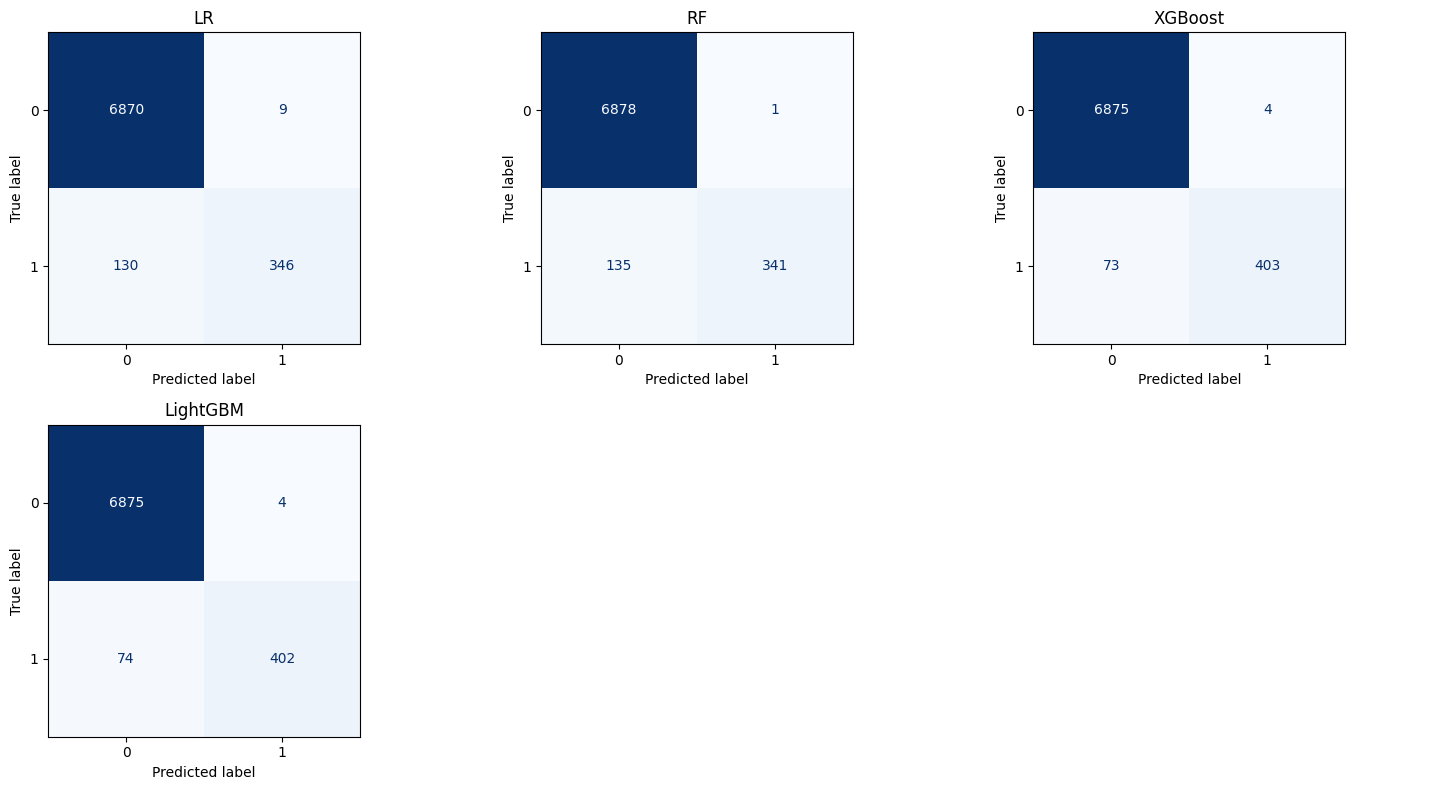

In [31]:
# Confusion Matrix 서브플롯 (환자 단위 집계 기준)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
import numpy as np

n_models = len(pred_scores_patient)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).reshape(-1)

for ax, (name, scores) in zip(axes, pred_scores_patient.items()):
    y_pred = (scores >= 0.5).astype(int)
    cm = confusion_matrix(y_patient, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name}")

for ax in axes[n_models:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [33]:
from __future__ import annotations

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def evaluate_patient_level(
    pred_scores_patient: dict[str, pd.Series | np.ndarray],
    y_patient: pd.Series | pd.DataFrame | np.ndarray,
    patient_ids: pd.Index | np.ndarray | None = None,
    threshold: float = 0.5,
) -> pd.DataFrame:
    """
    환자 단위 성능 평가 (정렬/정합 안전 버전)
    - y_patient / scores 모두 index(환자 id) 기반 정렬을 강제해서 순서 꼬임 방지
    """

    # -------------------------
    # 1) y_patient 표준화: 반드시 "y_true"라는 이름의 Series로 만들기
    # -------------------------
    if isinstance(y_patient, pd.DataFrame):
        if y_patient.shape[1] != 1:
            raise ValueError("y_patient이 DataFrame이면 컬럼이 1개여야 함 (환자당 1개 라벨).")
        y_patient_s = y_patient.iloc[:, 0]
    elif isinstance(y_patient, pd.Series):
        y_patient_s = y_patient
    else:  # ndarray
        if patient_ids is None:
            raise ValueError("y_patient이 ndarray이면 patient_ids를 꼭 제공해야 함.")
        y_patient_s = pd.Series(y_patient, index=pd.Index(patient_ids, name="patient_id"))

    # 핵심: 이름 강제
    y_patient_s = y_patient_s.rename("y_true")
    if y_patient_s.index.name is None:
        y_patient_s.index.name = "patient_id"

    results = []

    # -------------------------
    # 2) 모델별 score 정합 + metric 계산
    # -------------------------
    for name, scores in pred_scores_patient.items():
        # scores 표준화: 반드시 "score"라는 이름의 Series로 만들기
        if isinstance(scores, np.ndarray):
            if patient_ids is None:
                raise ValueError(f"[{name}] scores가 ndarray이면 patient_ids가 필요함.")
            scores_s = pd.Series(scores, index=pd.Index(patient_ids, name="patient_id"))
        else:
            scores_s = scores.copy()

        scores_s = scores_s.rename("score")
        if scores_s.index.name is None:
            scores_s.index.name = "patient_id"

        # 환자 id 기준으로 정렬/교집합 맞추기
        df_eval = pd.concat([y_patient_s, scores_s], axis=1).dropna()

        y_true = df_eval["y_true"].astype(int).to_numpy()
        y_score = df_eval["score"].astype(float).to_numpy()
        y_pred = (y_score >= threshold).astype(int)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # 한 클래스만 있으면 AUC/AP 계산 불가
        if np.unique(y_true).size < 2:
            auc = np.nan
            ap = np.nan
        else:
            auc = roc_auc_score(y_true, y_score)
            ap = average_precision_score(y_true, y_score)

        results.append({
            "model": name,
            "N_patients": len(df_eval),
            "pos_rate": float(y_true.mean()),
            "threshold": threshold,
            "ACC": acc,
            "PREC": prec,
            "REC": rec,
            "F1": f1,
            "AUC": auc,
            "PR-AUC": ap,
        })

    out = (
        pd.DataFrame(results)
        .set_index("model")
        .sort_values(["PR-AUC", "AUC"], ascending=False)
    )
    return out


# 실행
metrics_df = evaluate_patient_level(
    pred_scores_patient=pred_scores_patient,
    y_patient=y_patient,     # Series면 index=patient_id 인 게 가장 안전
    threshold=0.5
)

print(metrics_df.to_string(float_format=lambda x: f"{x:.4f}"))

          N_patients  pos_rate  threshold    ACC   PREC    REC     F1    AUC  PR-AUC
model                                                                               
LightGBM        7355    0.0647     0.5000 0.9894 0.9901 0.8445 0.9116 0.9977  0.9831
XGBoost         7355    0.0647     0.5000 0.9895 0.9902 0.8466 0.9128 0.9974  0.9812
RF              7355    0.0647     0.5000 0.9815 0.9971 0.7164 0.8337 0.9960  0.9754
LR              7355    0.0647     0.5000 0.9811 0.9746 0.7269 0.8327 0.9855  0.9383


In [29]:
for name, scores in pred_scores_patient.items():
    print(name, len(scores))
    break

LR 7355


In [30]:
print("N_rows(test_proc):", len(test_proc))
print("N_patients(test_proc):", test_proc["patient_id"].nunique())
print("len(y_patient):", len(y_patient))

N_rows(test_proc): 1217973
N_patients(test_proc): 5950
len(y_patient): 7355


In [1]:
# 트리 기반 모델 피처 중요도 시각화
import matplotlib.pyplot as plt
import pandas as pd

tree_models = {k: v for k, v in models.items() if k in ["RF", "XGBoost", "LightGBM"]}

for name, model in tree_models.items():
    if not hasattr(model, "feature_importances_"):
        continue

    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    top = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(6, 4))
    top.sort_values().plot(kind="barh")
    plt.title(f"{name} Feature Importance (Top 20)")
    plt.tight_layout()
    plt.show()


NameError: name 'models' is not defined

## SHAP 분석 (모델별)

/Users/ijaeyong/Desktop/Oracle_BC/mini_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP failed for LR: property 'feature_names_in_' of 'Pipeline' object has no setter
SHAP failed for RF: Data must be 1-dimensional, got ndarray of shape (111, 2) instead

XGBoost Top 30 features:
feature10           0.656308
feature9            0.385389
feature14_tsince    0.344345
feature1            0.342957
feature14           0.340802
feature4            0.267891
feature5            0.266788
feature31           0.257142
feature25           0.256078
feature11           0.239819
feature12_tsince    0.214387
feature21           0.207872
feature27           0.198450
feature18           0.189097
feature27_tsince    0.183940
feature20           0.173165
feature28           0.164671
feature3            0.159114
feature32           0.153990
feature26_tsince    0.152708
feature12           0.148304
feature26           0.146355
feature30_tsince    0.144496
feature32_tsince    0.142541
feature22           0.126341
feature34_tsince    0.122555
feature31_tsince    0.115933
feature7            0

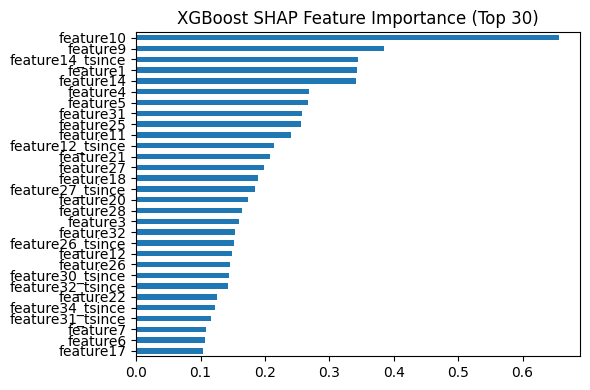

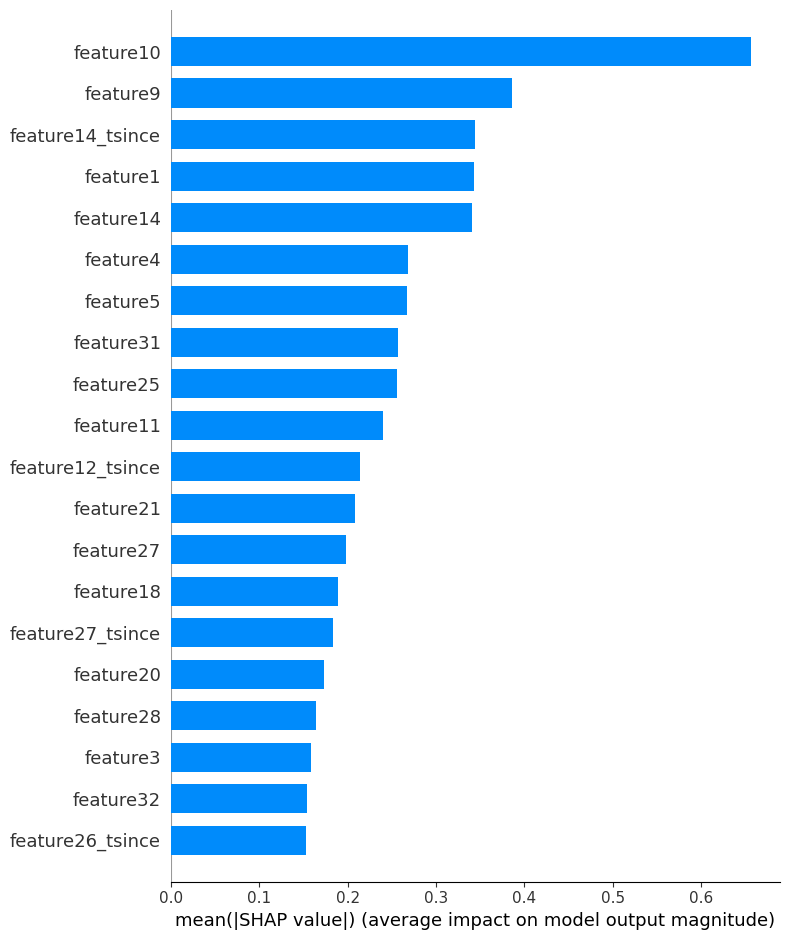

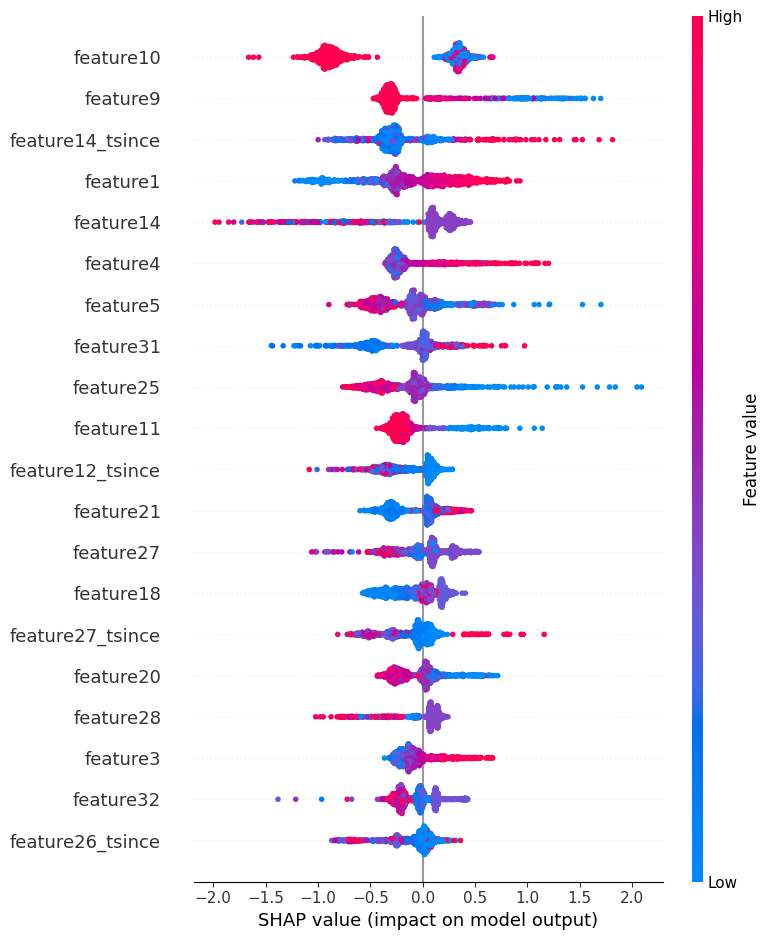


LightGBM Top 30 features:
feature10           0.486097
feature14           0.403357
feature1            0.365217
feature9            0.285407
feature12_tsince    0.276013
feature31           0.271013
feature4            0.254277
feature14_tsince    0.251114
feature18           0.246141
feature25           0.244538
feature5            0.225330
feature21           0.196309
feature20           0.187636
feature27           0.182076
feature27_tsince    0.169443
feature26           0.167476
feature26_tsince    0.162126
feature28           0.160804
feature32           0.159191
feature11           0.153092
feature3            0.150737
feature22           0.127577
feature31_tsince    0.124276
feature32_tsince    0.124028
feature17           0.122354
feature12           0.119770
feature7            0.110654
feature30_tsince    0.109845
feature19_tsince    0.103107
feature34_tsince    0.101901
dtype: float64


/Users/ijaeyong/Desktop/Oracle_BC/mini_project/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


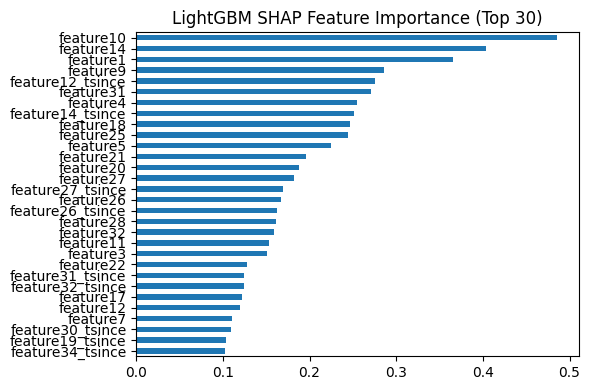

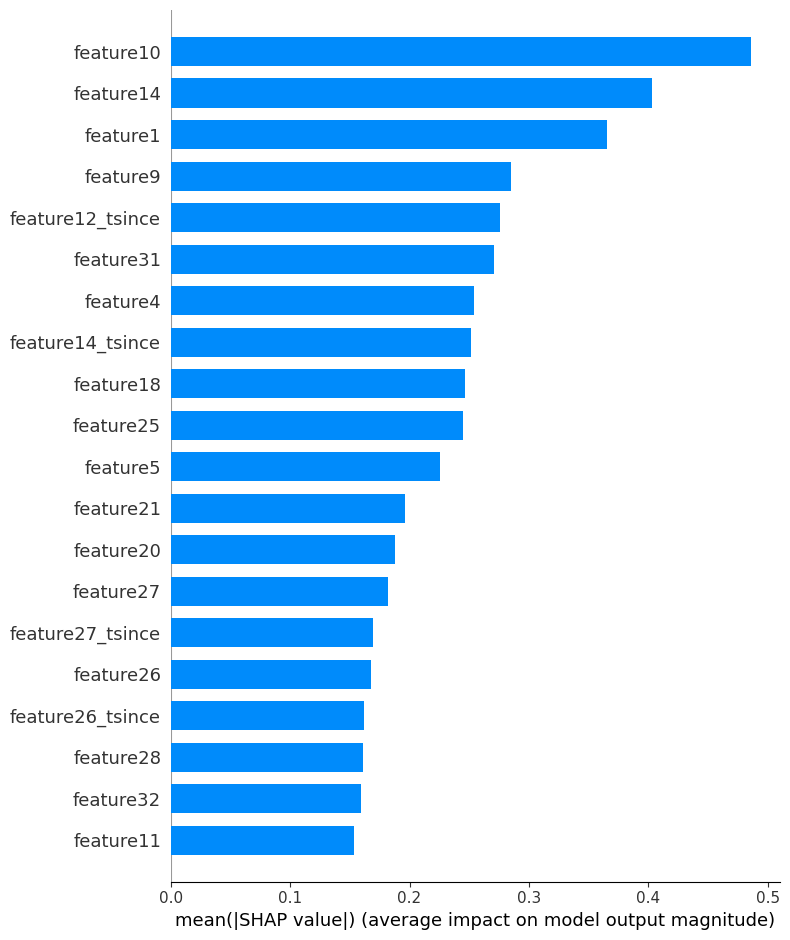

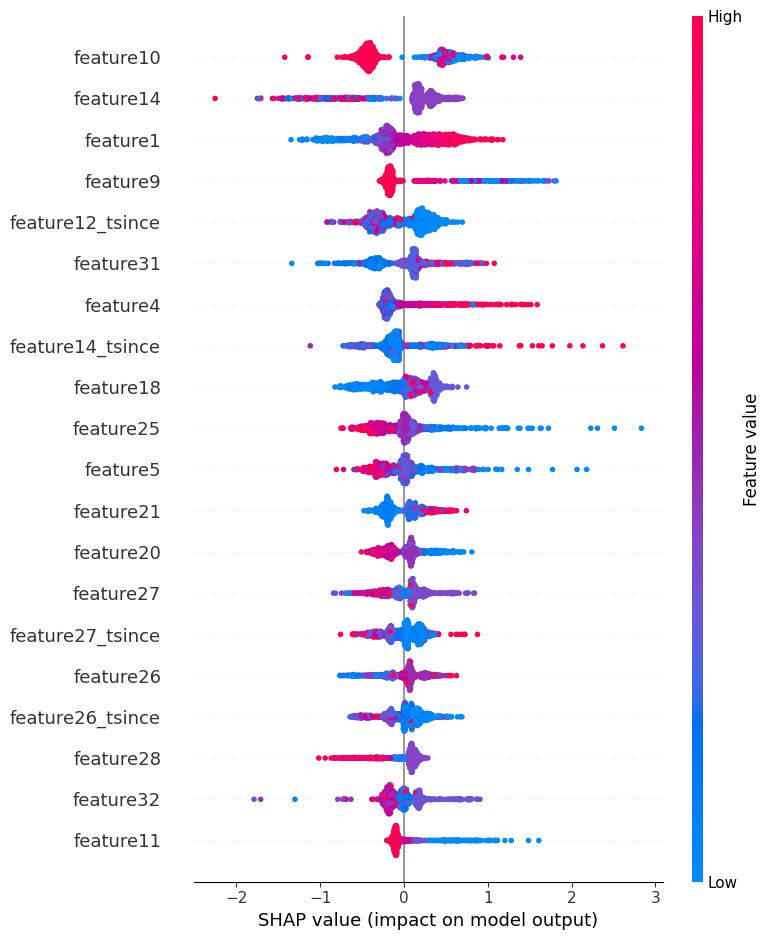

In [34]:
# SHAP 분석 + 중요 피처 Top-N (시간 포인트 단위 모델 기준)
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X_shap = X_test.sample(n=min(1000, len(X_test)), random_state=42)
top_n = 30

for name, model in models.items():
    try:
        if name in ["RF", "XGBoost", "LightGBM"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_shap)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, X_shap.sample(100, random_state=42))
            shap_values = explainer.shap_values(X_shap, nsamples=100)

        if isinstance(shap_values, list) and len(shap_values) > 1:
            sv = shap_values[1]
        else:
            sv = shap_values

        mean_abs = np.abs(sv).mean(axis=0)
        imp = pd.Series(mean_abs, index=X_shap.columns).sort_values(ascending=False)

        print(f"\n{name} Top {top_n} features:")
        print(imp.head(top_n))

        plt.figure(figsize=(6, 4))
        imp.head(top_n).sort_values().plot(kind="barh")
        plt.title(f"{name} SHAP Feature Importance (Top {top_n})")
        plt.tight_layout()
        plt.show()

        shap.summary_plot(sv, X_shap, show=True, plot_type="bar")
        shap.summary_plot(sv, X_shap, show=True)
    except Exception as e:
        print(f"SHAP failed for {name}: {e}")


,feature10,feature9,feature14_tsince,feature1,feature14,feature4,feature5,feature31,feature25,feature11
feature10,1.000000,0.629872,-0.206617,-0.013165,0.090410,-0.056012,0.068790,-0.056097,0.079652,0.694226
feature9,0.629872,1.000000,-0.176281,-0.011250,0.065077,-0.048523,0.079206,-0.102058,0.152697,0.796759
feature14_tsince,-0.206617,-0.176281,1.000000,0.033506,-0.030413,0.065796,-0.024888,0.024065,0.097586,-0.135026
feature1,-0.013165,-0.011250,0.033506,1.000000,-0.038597,-0.147378,-0.007568,0.035512,0.020321,-0.005469
feature14,0.090410,0.065077,-0.030413,-0.038597,1.000000,-0.060181,0.064070,-0.022100,0.048143,0.052508
feature4,-0.056012,-0.048523,0.065796,-0.147378,-0.060181,1.000000,-0.006483,0.052243,-0.043502,-0.027190
feature5,0.068790,0.079206,-0.024888,-0.007568,0.064070,-0.006483,1.000000,-0.102477,0.056513,0.078941
feature31,-0.056097,-0.102058,0.024065,0.035512,-0.022100,0.052243,-0.102477,1.000000,-0.119960,-0.084387
feature25,0.079652,0.152697,0.097586,0.020321,0.048143,-0.043502,0.056513,-0.119960,1.000000,0.140769
feature11,0.694226,0.796759,-0.135026,-0.005469,0.052508,-0.027190,0.078941,-0.084387,0.140769,1.000000


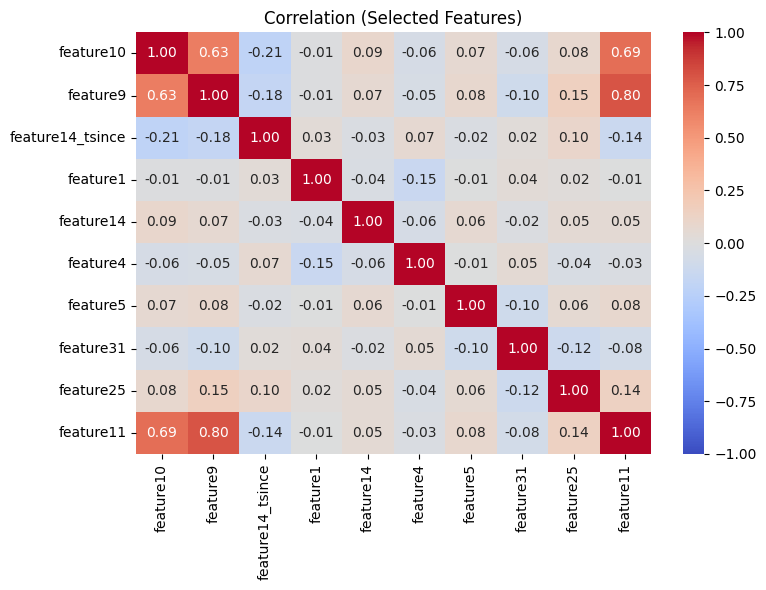

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = [
    "feature10", "feature9", "feature14_tsince", "feature1", "feature14",
    "feature4", "feature5", "feature31", "feature25", "feature11"
]

# 상관관계 계산
corr = X_train[cols].corr(method="pearson")
display(corr)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation (Selected Features)")
plt.tight_layout()
plt.show()


,died_in_icu=0,died_in_icu=1
feature9,0.851138,0.885117
feature10,0.850799,0.884539
feature11,0.850555,0.884125


<Figure size 600x300 with 0 Axes>

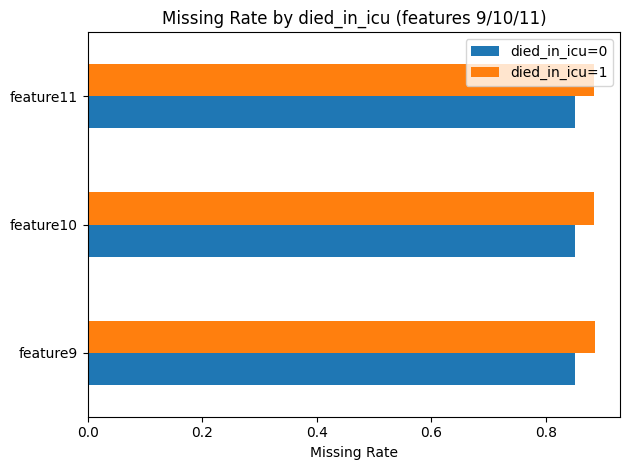

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# ====== (2) 사망/생존(타깃)별 Missing Value rate ======
def missing_report_by_target(df, target_col):
    total = df.groupby(target_col).size()
    missing_cnt = df.isna().groupby(df[target_col]).sum()
    missing_rate = missing_cnt.div(total, axis=0)

    # 컬럼별 정렬 (전체 결측률 기준)
    overall_rate = df.isna().mean().sort_values(ascending=False)
    missing_cnt = missing_cnt[overall_rate.index]
    missing_rate = missing_rate[overall_rate.index]

    return missing_cnt, missing_rate

# ====== (3) 10개씩 끊어서 출력 ======
def display_in_chunks(df, chunk_size=10):
    for i in range(0, len(df), chunk_size):
        display(df.iloc[i:i+chunk_size])

# ====== 실행 예시 ======
df_raw = train_df  # 전처리 전 데이터프레임
target_col = "died_in_icu"  # 타깃 컬럼명


# (2) 타깃별 결측 리포트
# 보고 싶은 피처만 지정
target_features = ["feature9", "feature10", "feature11"]

# 타깃별 결측 리포트
missing_cnt_by_t, missing_rate_by_t = missing_report_by_target(df_raw, target_col)

# 전치 후 피처 필터링
missing_rate_by_t_T = missing_rate_by_t.T
missing_rate_by_t_T.columns = [f"{target_col}={c}" for c in missing_rate_by_t_T.columns]

filtered = missing_rate_by_t_T.loc[target_features]
display(filtered)

# 시각화
plt.figure(figsize=(6, 3))
filtered.plot(kind="barh")
plt.title(f"Missing Rate by {target_col} (features 9/10/11)")
plt.xlabel("Missing Rate")
plt.tight_layout()
plt.show()



In [39]:
target_col = "died_in_icu"  # 사망/생존 라벨 컬럼명
col = "observationoffset"

mean_by_target = train_df.groupby(target_col)[col].mean()
display(mean_by_target.to_frame(name="mean"))


,mean
died_in_icu,
0,8542.256359
1,10818.957448


In [40]:
target_col = "died_in_icu"
time_col = "observationoffset"

# stay_id 컬럼명 지정 (둘 중 존재하는 걸로 자동 선택)
possible_group_cols = ["patientunitstayid", "patient_id", "stay_id"]
group_col = next((c for c in possible_group_cols if c in train_df.columns), None)
if group_col is None:
    raise ValueError("stay_id 컬럼을 찾을 수 없습니다.")

# stay_id별 observationoffset 개수
counts_per_stay = (
    train_df
    .groupby([group_col, target_col])[time_col]
    .count()
    .reset_index(name="obs_count")
)

# 사망/생존 그룹별 평균
mean_counts = counts_per_stay.groupby(target_col)["obs_count"].mean()
display(mean_counts.to_frame(name="mean_obs_count"))


,mean_obs_count
died_in_icu,
0,173.588082
1,41.795276
